# IT 402

## Assignment 4 - Naive Bayes

### Name: Niraj Nandish

### Roll no.: 191IT234


In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings("ignore")


In [2]:
class NaiveBayes:
    def gaussian_fit(self, X, Y):
        self.n_samples, self.n_features = X.shape
        self.n_classes = len(np.unique(Y))

        self.mean = np.zeros((self.n_classes, self.n_features))
        self.var = np.zeros((self.n_classes, self.n_features))
        self.prior_pred = np.zeros(self.n_classes)

        for clas in range(self.n_classes):
            X_c = X[Y == clas]

            self.mean[clas, :] = np.mean(X_c, axis=0)
            self.var[clas, :] = np.var(X_c, axis=0)
            self.prior_pred[clas] = X_c.shape[0] / self.n_samples

    def gaussian_predict(self, X):
        pred = [self.get_gaussian_probability(x) for x in X]
        return pred

    def get_gaussian_probability(self, x):
        post_prob = []

        for clas in range(self.n_classes):
            mean = self.mean[clas]
            vari = self.var[clas]
            prior_pred = np.log(self.prior_pred[clas])

            post_pred = np.sum(np.log(self.gaussian_density(x, mean, vari)))
            post_pred = prior_pred + post_pred
            post_prob.append(post_pred)

        return np.argmax(post_prob)

    def gaussian_density(self, x, mean, variance):
        const = 1 / np.sqrt(2 * np.pi * variance)
        prob = np.exp(-0.5 * ((x - mean) ** 2 / variance))

        return const * prob

    def discrete_fit(self, X, y):
        self.n_samples, self.n_features = X.shape
        self.n_classes = len(np.unique(y))
        self.likelihood_prob = np.zeros((self.n_classes, self.n_features))
        self.prior_prob = np.zeros(self.n_classes)

        for clas in range(self.n_classes):
            x = X[y == clas]
            self.prior_prob[clas] = x.shape[0] / self.n_samples

            for feature in range(self.n_features):
                self.likelihood_prob[clas][feature] = np.log(
                    (np.sum(x[:, feature]) + 1) / (len(x) + 1)
                )

    def discrete_predict(self, X):
        pred = [self.get_discrete_probability(x) for x in X]
        return pred

    def get_discrete_probability(self, x):
        post_prob = []

        for clas in range(self.n_classes):
            post_prob.append(
                np.sum(self.likelihood_prob[clas]) + np.log(self.prior_prob[clas])
            )

        return np.argmax(post_prob)


In [3]:
def performance_measures_continuous(cm):
    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    print_tpr = "\n".join([f" {i} --> {tprr:.03f}" for i, tprr in enumerate(tpr)])
    print_fpr = "\n".join([f" {i} --> {fprr:.03f}" for i, fprr in enumerate(fpr)])

    print(f"\nTrue Positive Rate for each class:\n{print_tpr}")
    print(f"\nFalse Positive Rate for each class:\n{print_fpr}")

    return tp, fp, tn, fn


def performance_measures_discrete(test_y, y_pred):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for i in range(len(test_y)):
        if test_y[i] == y_pred[i] == 1:
            tp += 1
        if test_y[i] != y_pred[i] and test_y[i] == 1:
            fn += 1
        if test_y[i] == y_pred[i] == 0:
            tn += 1
        if test_y[i] != y_pred[i] and test_y[i] == 0:
            fp += 1

    print(f"\nTrue Positive Rate = {tp/(tp+fn):.03f}")
    print(f"False Positive Rate = {fp/(fp+tn):.03f}")

    return tp, fp, tn, fn


def relative_absolute_error(y_test, y_pred):
    return abs(y_test - y_pred).sum() / abs(y_test - y_test.mean()).sum()


# IRIS Dataset

In [4]:
iris_data = load_iris()
df = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
df["target"] = iris_data.target

df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=23)

X_train = train_df.to_numpy().T[:-1].T
y_train = train_df.to_numpy().T[-1].T
X_test = test_df.to_numpy().T[:-1].T
y_test = test_df.to_numpy().T[-1].T

model = NaiveBayes()
model.gaussian_fit(X_train, y_train)
y_pred = model.gaussian_predict(X_test)


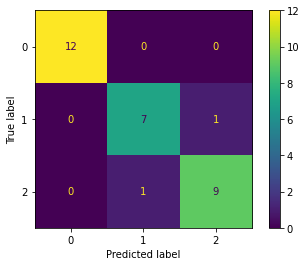

In [6]:
corr_res = len(y_test[y_test == y_pred])
incorr_res = len(y_test) - corr_res

cm = confusion_matrix(y_test.tolist(), y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()


In [7]:
print(f"Correctly classified instances: {corr_res}")
print(f"Incorrectly classified instances: {incorr_res}")
print(f"\nKappa Score: {cohen_kappa_score(y_test.tolist(), y_pred)}")
print(f"\nRoot Mean Square Error (RMSE): {np.sqrt(((y_pred - y_test) ** 2).mean())}")
print(f"\nRelative Absolute Error (RAE): {relative_absolute_error(y_test, y_pred)}")
print(f"\nMean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
tp, fp, tn, fn = performance_measures_continuous(cm)
print(f"\nAccuracy: {100*accuracy_score(y_test, y_pred):.3f} %")


Correctly classified instances: 28
Incorrectly classified instances: 2

Kappa Score: 0.8986486486486487

Root Mean Square Error (RMSE): 0.2581988897471611

Relative Absolute Error (RAE): 0.08928571428571429

Mean Absolute Error (MAE): 0.06666666666666667

True Positive Rate for each class:
 0 --> 1.000
 1 --> 0.875
 2 --> 0.900

False Positive Rate for each class:
 0 --> 0.000
 1 --> 0.045
 2 --> 0.050

Accuracy: 93.333 %


# Heart Dataset

In [8]:
df = pd.read_excel("Heart_Dataset.xlsx", header=None, sheet_name="Sheet1")
df.head()


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,0,0,0,1,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,0
1,1,0,0,1,1,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,1
2,1,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
4,1,0,0,0,0,0,0,0,1,0,...,1,0,1,1,0,0,0,0,0,0


In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=31)

X_train = train_df.to_numpy().T[1:].T
y_train = train_df.to_numpy().T[0].T
X_test = test_df.to_numpy().T[1:].T
y_test = test_df.to_numpy().T[0].T

model = NaiveBayes()
model.discrete_fit(X_train, y_train)
y_pred = model.discrete_predict(X_test)


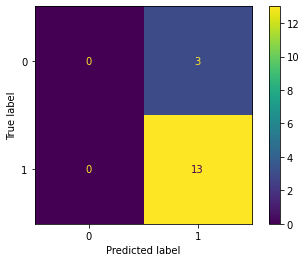

In [10]:
corr_res = len(y_test[y_test == y_pred])
incorr_res = len(y_test) - corr_res

cm = confusion_matrix(y_test.tolist(), y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()
plt.show()


In [11]:
print(f"Correctly classified instances: {corr_res}")
print(f"Incorrectly classified instances: {incorr_res}")
print(f"\nKappa Score: {cohen_kappa_score(y_test.tolist(), y_pred)}")
print(f"\nRoot Mean Square Error (RMSE): {np.sqrt(((y_pred - y_test) ** 2).mean())}")
print(f"\nRelative Absolute Error (RAE): {relative_absolute_error(y_test, y_pred)}")
print(f"\nMean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
tp, fp, tn, fn = performance_measures_discrete(y_test, y_pred)
print(f"\nAccuracy: {100*accuracy_score(y_test, y_pred):.3f} %")


Correctly classified instances: 13
Incorrectly classified instances: 3

Kappa Score: 0.0

Root Mean Square Error (RMSE): 0.4330127018922193

Relative Absolute Error (RAE): 0.6153846153846154

Mean Absolute Error (MAE): 0.1875

True Positive Rate = 1.000
False Positive Rate = 1.000

Accuracy: 81.250 %
